In [1]:
import codecs
import re
from nltk import tokenize
from nltk.parse import stanford
import os
from nltk.tag import StanfordPOSTagger
from nltk.tree import ParentedTree
from IPython.display import Image, display

In [2]:
def RemoveShortStubs(paragraphs):
    startStub = [(u'It', u'PRP'), (u'it', u'PRP'), (u'There', u'EX'), (u'there', u'EX')]
    endStub = (u'that', u'IN')
    for par in paragraphs:
        for sent in par:
            startidx = []
            endidx = []
            for i, word in enumerate(sent):
                if word in startStub:
                    flag = 1
                    start_candidate = i
                if (word == endStub) and (flag == 1):
                    flag = 0
                    startidx.append(start_candidate)
                    endidx.append(i)
            for stubidx in reversed(range(len(startidx))):
                del sent[startidx[stubidx]: endidx[stubidx] + 1]
            

In [3]:
def PreProcess(text):
    #Deleting literature references
    #\\b - word bounder; [^ ]*? - any sequance of characters except ' '; [([] \\d+ [])] - number in brackets
    #pat = re.compile(u"\\b[^ ]*?[([]\\d+[])]", re.IGNORECASE or re.DOTALL)
    #text = re.sub(pat, u"", text)
    #[([] -open bracket ( or [;  [^([]*? - lazy; \d+ - number; [^])]*?; [])] - close bracket ) or ]
    pat = re.compile(r"[([][^([]*?\d+[^])]*?[])]", re.IGNORECASE or re.DOTALL)
    text = re.sub(pat, r"", text)
    text = re.sub(r'([,.:;"])', r' \g<1> ', text)
    
    #Splitting into paragraphs
    paragraphs = re.split(u"\n", text)
    #Splitting into sentences
    for i, par in enumerate(paragraphs):
        paragraphs[i] = tokenize.sent_tokenize(par)
    #Tagging all words
    st = StanfordPOSTagger('english-bidirectional-distsim.tagger')
    for i, par in enumerate(paragraphs):
        for sentence in range(len(par)):
            paragraphs[i][sentence] = st.tag(paragraphs[i][sentence].split())
    RemoveShortStubs(paragraphs)
    return paragraphs

In [4]:
with codecs.open(u"text_test", 'r', 'utf-8') as fin:
        text = fin.read()
paragraphs = PreProcess(text)
#debug print
#for par in paragraphs:
#    for sentence in par:
#        print sentence, '\n'
#    print '\n'

In [5]:
class SourceText:
    def __init__(self, paragraphs):
        self._paragraphs = [x for x in paragraphs if x != []]
        self._par_iter = 0
        self._sent_iter = 0
        
    def nextPar(self):
        self._par_iter += 1
        if self._par_iter == len(self._paragraphs):
            return 1
        else:
            self._sent_iter = 0
            return 0
        
    def nextSent(self):
        if self._sent_iter < len(self._paragraphs[self._par_iter]):
            self._sent_iter += 1
            return self._paragraphs[self._par_iter][self._sent_iter - 1], 0
        else:
            return [], 1

In [66]:
NOT_APPLICABLE = 0
UNKNOWN = 1
FLUID = 2
class SentInfo:
    _placebo_words = [u"Additionally", u"Also", u"And", u"Another", u"Besides", u"Furthermore", u"However", u"In addition",\
                 u"Meanwhile", u"Moreover", u"On the other hand", u"Other", u"The above mentioned", u"The former",\
                 u"The latter", u"The other", u"To add"]
    _fluid_words = [u"admittedly,", u"all in all", u"as a result,", u"because", u"conversely", u"equally,", u"finally",\
               u"for example", u"in a similar", u"in contrast", u"in summary", u"initially", u"last", u"nevertheless",\
               u"once", u"so far", u"such", u"after", u"along these lines,", u"as expected", u"before", u"curiously",\
               u"even though", u"first", u"for instance", u"in a way", u"in other words", u"in the first",\
               u"interestingly", u"lastly", u"next", u"regardless", u"specifically,", u"surprisingly,", u"afterward",\
               u"although", u"as soon as,", u"but", u"despite", u"eventually", u"firstly", u"for this reason,",\
               u"in comparison,", u"in particular", u"in the same way", u"it follows", u"likewise", u"nonetheless",\
               u"similarly", u"still,", u"that is why,", u"again", u"as a consequence", u"be that as it may",\
               u"consequently", u"during", u"figure", u"following", u"in a certain sense", u"in conclusion", u"in short",\
               u"indeed", u"it is as if,", u"meanwhile,", u"now,", u"so", u"subsequently,", u"the first", u"the last",\
               u"this", u"to elaborate", u"the next,", u"this is why", u"to explain,", u"the reason", u"thus",\
               u"to illustrate", u"then", u"to conclude,", u"to put it another way", u"to put it succinctly",\
               u"unexpectedly", u"while", u"to sum up", u"until", u"while,", u"to summarize,", u"up to now,", u"yet",\
               u"ultimately", u"whereas"]
    _parser = stanford.StanfordParser(model_path="edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")
    def __init__(self, sentence, type):
        self.sent = sentence
        self.type = type
        self.topic_strong_words = []
        self.topic_weak_words = []
        self.stress_strong_words = []
        self.stress_weak_words = []
        self.hasPlaceboTransitions = -1
    
    def _deleteNonMainClauses(self, tree):
        idxs = tree.treepositions()
        for s in list(tree.subtrees(lambda t: t.label() == u"SBAR" or t.label() == u"SBARQ")):
            idx = -1
            for x in idxs:
                try:
                    if s == tree[x]:
                        idx = x
                except IndexError:
                    continue
            if idx != -1:
                del tree[idx]
        return tree
    
    def _recursive_search(self, tree, subj_list):
        if tree.height() == 2 or (tree.height() == 3 and len(tree.leaves()) == 1):
            subj_list.extend(tree.leaves())
        else:
            for np_idx in range(len(tree)):
                l = tree[np_idx].label()
                target_tags = [u"NP", u"NN", u"NNS", u"PRP", u"CD"]
                if  l in target_tags:
                    self._recursive_search(tree[np_idx], subj_list)    
    
    def _findSubjects(self, tree):
        res = []
        for s in list(tree.subtrees(lambda t: t.label() == u"S")):
            child_labels_list = []
            for i in range(len(s)):
                child_labels_list.append(s[i].label())
            if u"NP" in child_labels_list and u"VP" in child_labels_list:
                for np_idx in range(len(s)):
                    if s[np_idx].label() == u"NP":
                        self._recursive_search(s[np_idx], res)
        return res
    
    def setDefaultWordSet(self):
        self.topic_weak_words = []
        self.topic_strong_words = []
        self.stress_weak_words = []
        self.stress_strong_words = []
        tree = next(self._parser.tagged_parse(self.sent))            
        display(tree)
        #Добавляем все слова с метками NN, NNS, NNP, NNPS
        #Отличить verb derived nouns в VBG
        target_tags = [u"NN", u"NNP", u"NNS", u"NNPS", u"VBG"]
        for tup in self.sent:
            if tup[1] in target_tags:
                self.stress_words.append(tup[0])
        #Удаляем non main clauses
        tree = self._deleteNonMainClauses(tree)
        #Ищем subjects
        self.topic_words = self._findSubjects(tree)
        self.stress_words = [x for x in self.stress_words if x not in self.topic_words]
    #Check this function does not work properly(because we can not find expression of 2 words or more)
    def checkPlaceboTransitions(self):
        if self.sent[0][0] in self._placebo_words:
            self.hasPlaceboTransitions = 1
        else:
            self.hasPlaceboTransitions = 0
    def sentenceBeginsWithFluidWords(self):
        verb_tags = [u"VB", u"VBD", u"VBN", u"VBP", u"VBZ"]
        pronouns_tags = [u"PRP$", u"PRP"]
        patt = re.compile(u"(?:[A-Z]+\\)|\\([A-Z]+\\)|[1-9]+\\)|\\([1-9]+\\)|[1-9]*1st|[1-9]*2nd|[1-9]*3rd|[4-9]th|[1-9]+0th)")
        for word in self.sent:
            if word[1] in verb_tags:
                break
            #Check regexes(do not know how to implement ordinal numbers)
            if (word[0] in self._fluid_words) or (word[1] in pronouns_tags) or (re.search(patt, word[0]) != None):
                return 1
        return 0
        

0


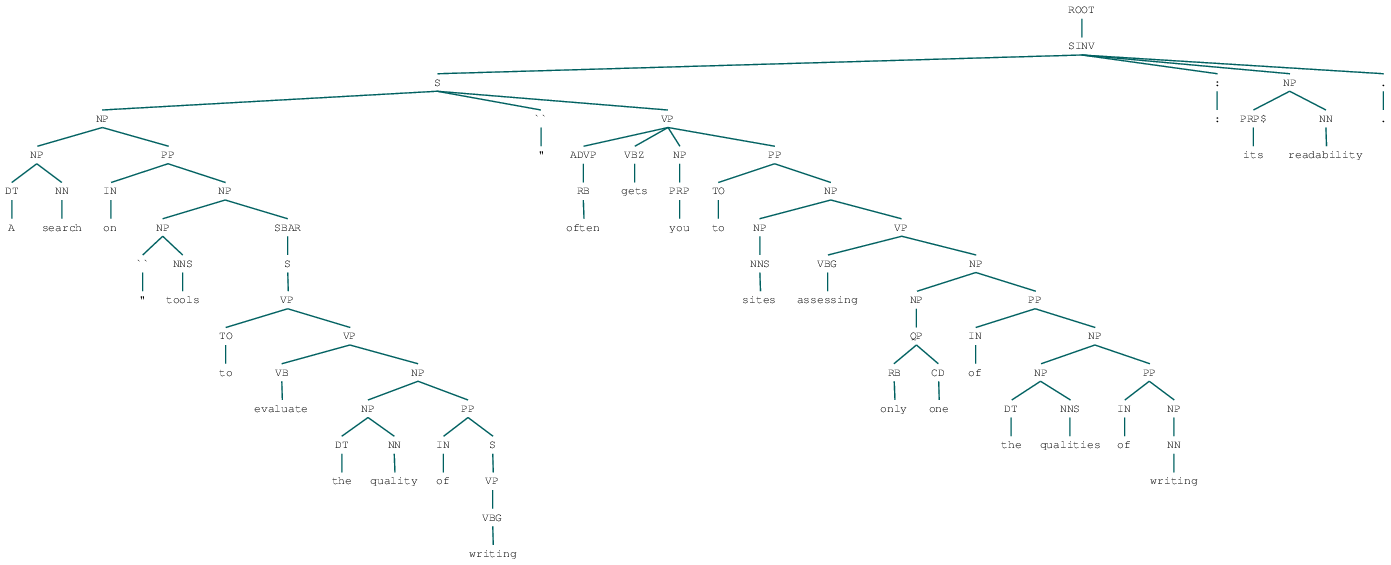

stress:  [u'tools', u'quality', u'writing', u'sites', u'assessing', u'qualities', u'writing', u'readability']
topic:  [u'search']


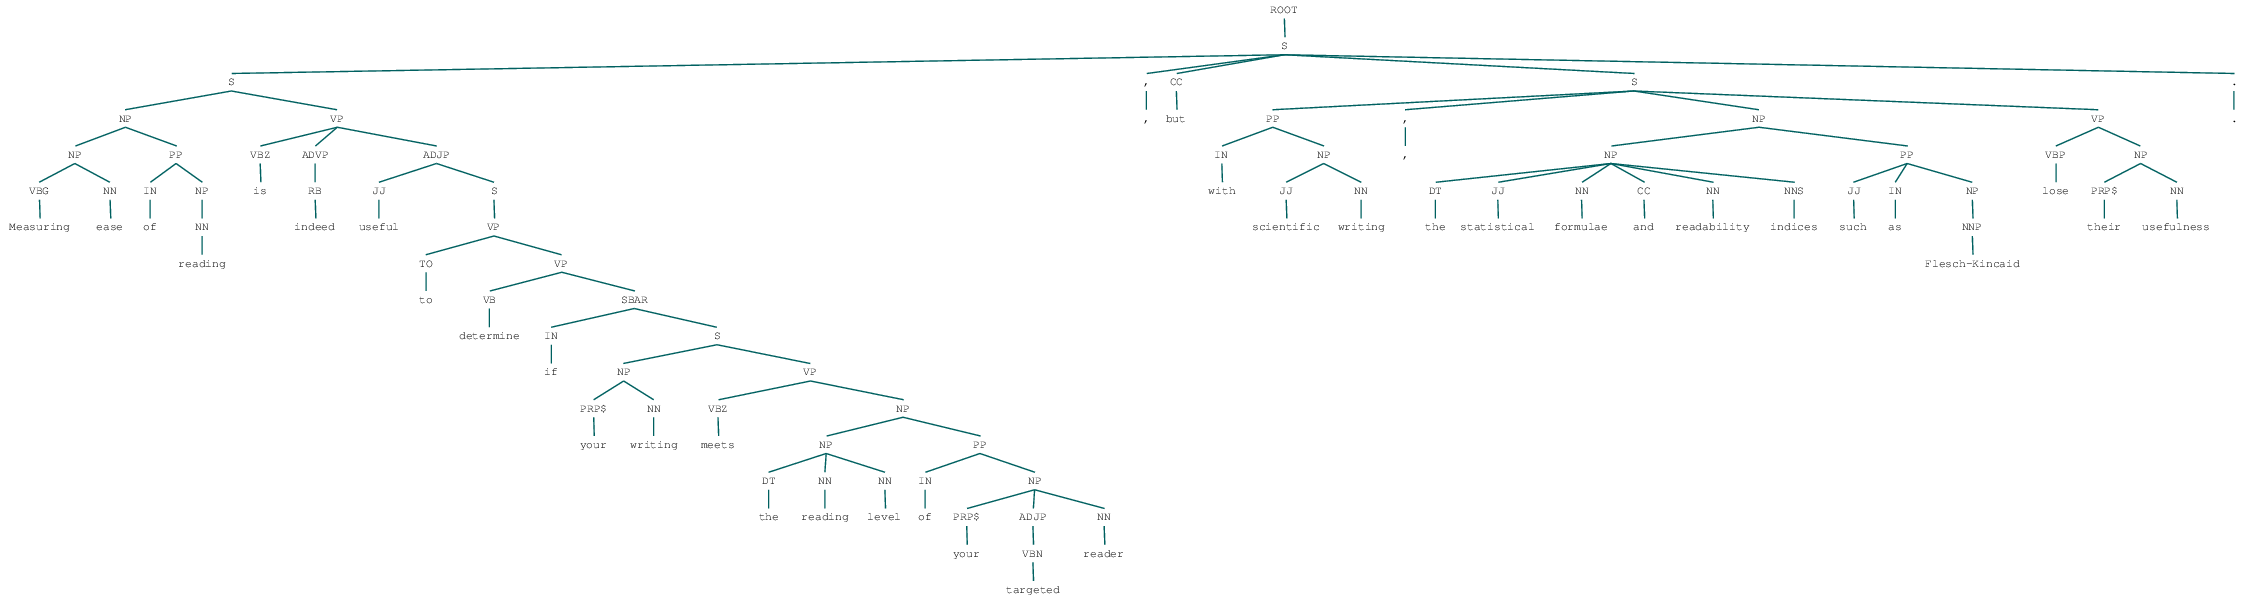

stress:  [u'Measuring', u'reading', u'writing', u'reading', u'level', u'reader', u'writing', u'Flesch-Kincaid', u'usefulness']
topic:  [u'ease', u'formulae', u'readability', u'indices']
0 PAR ITER
4
_par_iter: 1
_sent_iter: 3
0


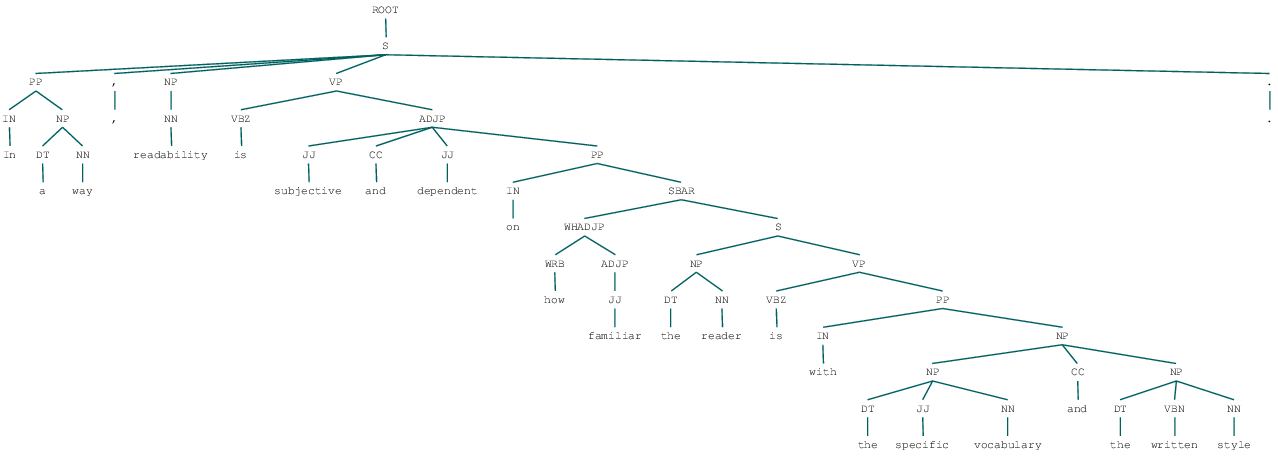

stress:  [u'way', u'reader', u'vocabulary', u'style']
topic:  [u'readability']


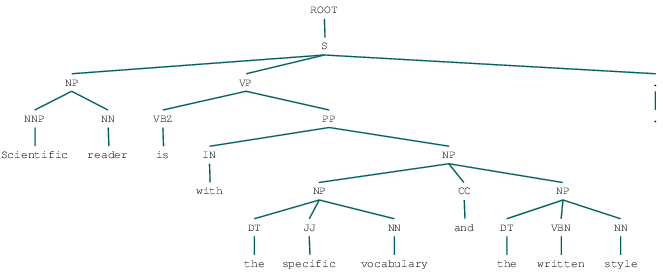

stress:  [u'Scientific', u'vocabulary', u'style']
topic:  [u'reader']


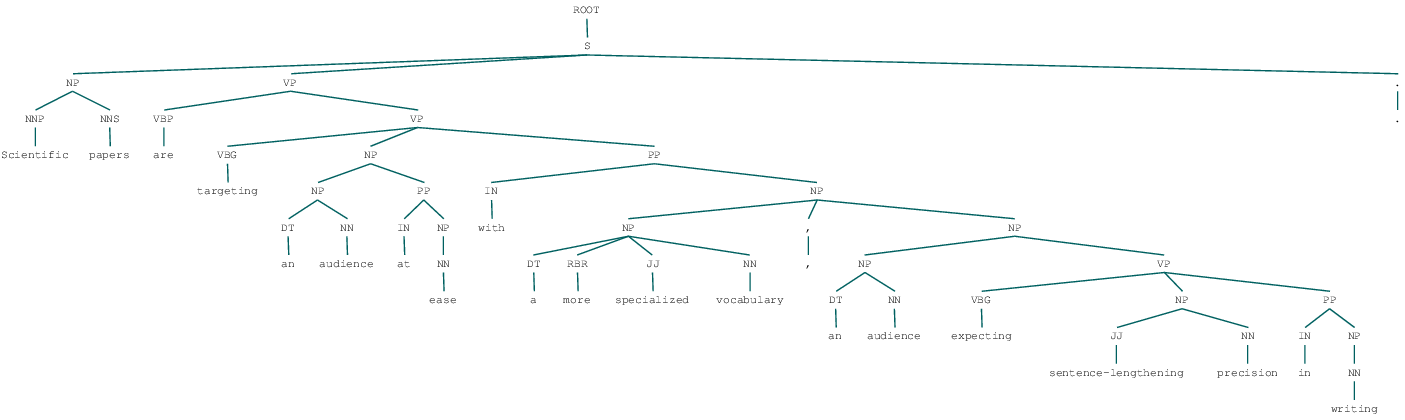

stress:  [u'Scientific', u'targeting', u'audience', u'ease', u'vocabulary', u'audience', u'expecting', u'precision', u'writing']
topic:  [u'papers']


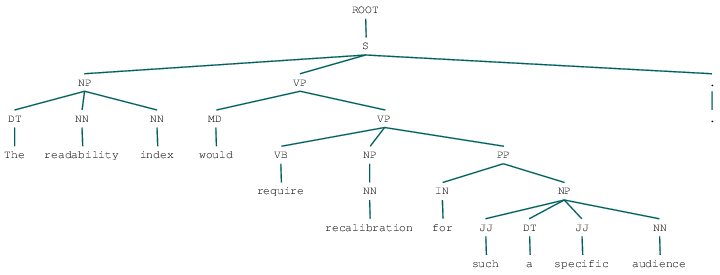

stress:  [u'recalibration', u'audience']
topic:  [u'readability', u'index']


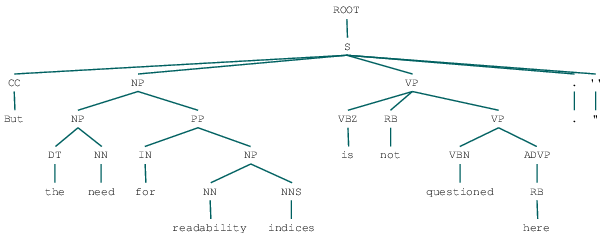

stress:  [u'readability', u'indices']
topic:  [u'need']


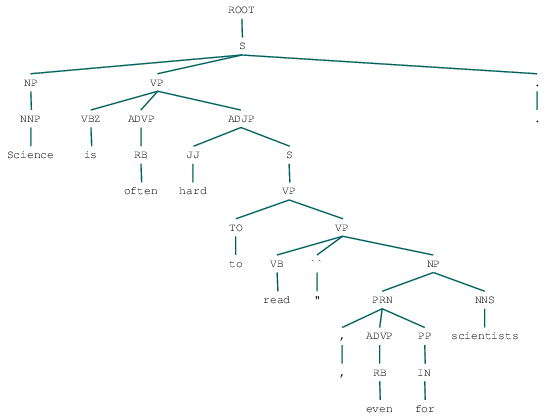

stress:  [u'scientists']
topic:  [u'Science']
1 PAR ITER
4
_par_iter: 2
_sent_iter: 7
0


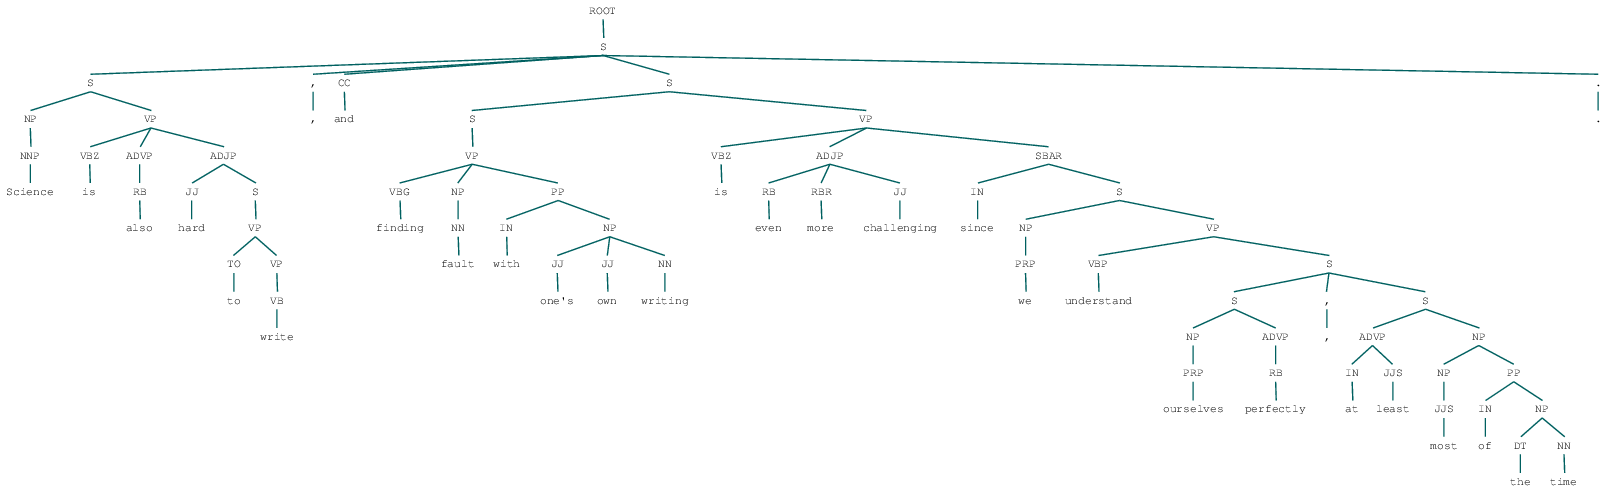

stress:  [u'finding', u'fault', u'writing', u'time']
topic:  [u'Science']


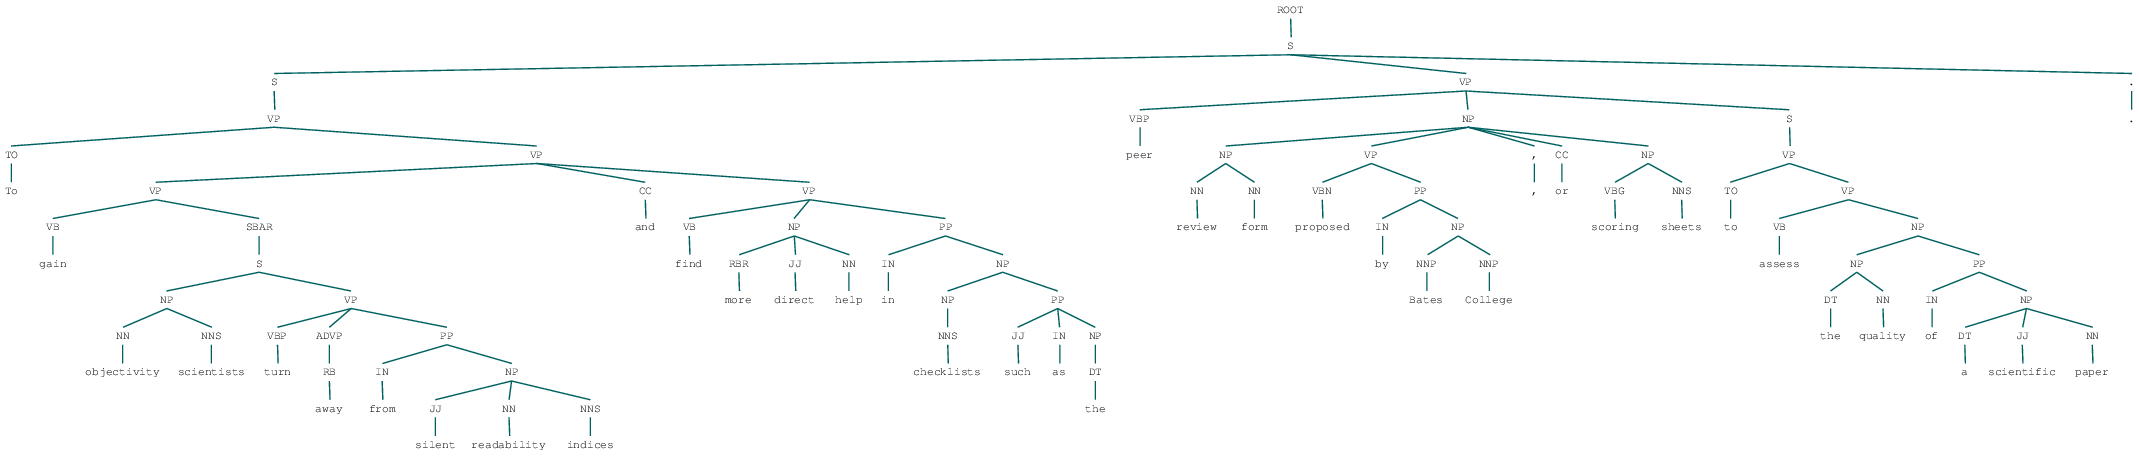

stress:  [u'objectivity', u'scientists', u'readability', u'indices', u'help', u'checklists', u'review', u'form', u'Bates', u'College', u'scoring', u'sheets', u'quality', u'paper']
topic:  []


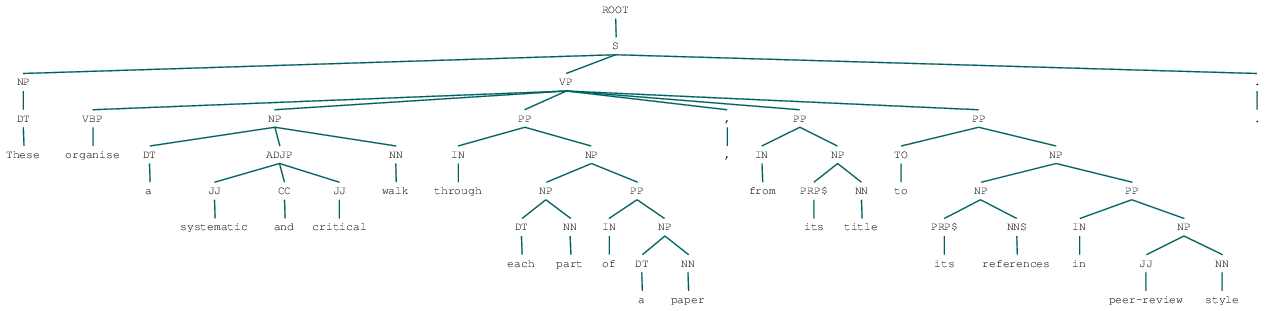

stress:  [u'walk', u'part', u'paper', u'title', u'references', u'style']
topic:  [u'These']


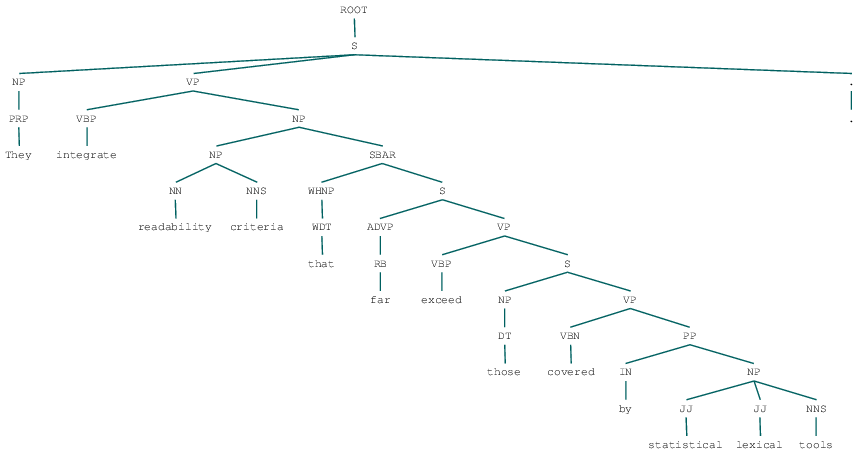

stress:  [u'readability', u'criteria', u'tools']
topic:  [u'They']


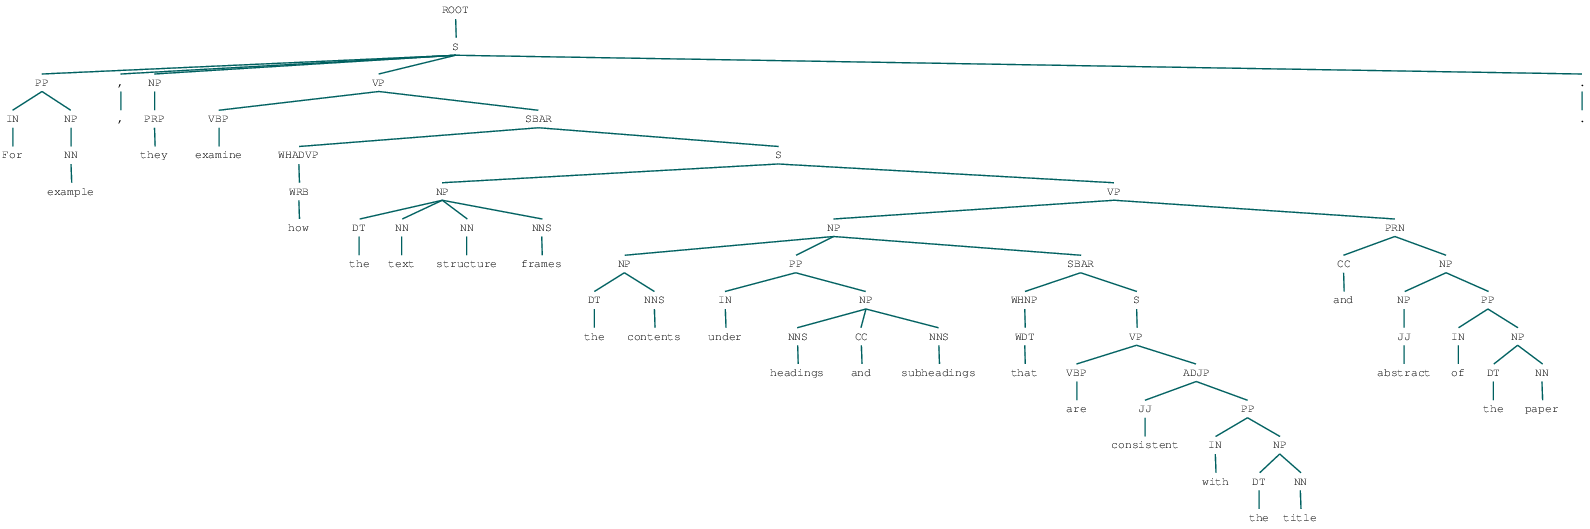

stress:  [u'example', u'text', u'structure', u'frames', u'contents', u'headings', u'subheadings', u'title', u'paper']
topic:  [u'they']


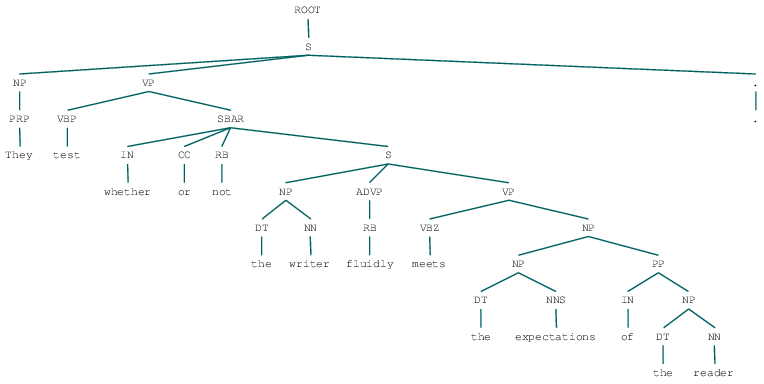

stress:  [u'writer', u'expectations', u'reader']
topic:  [u'They']


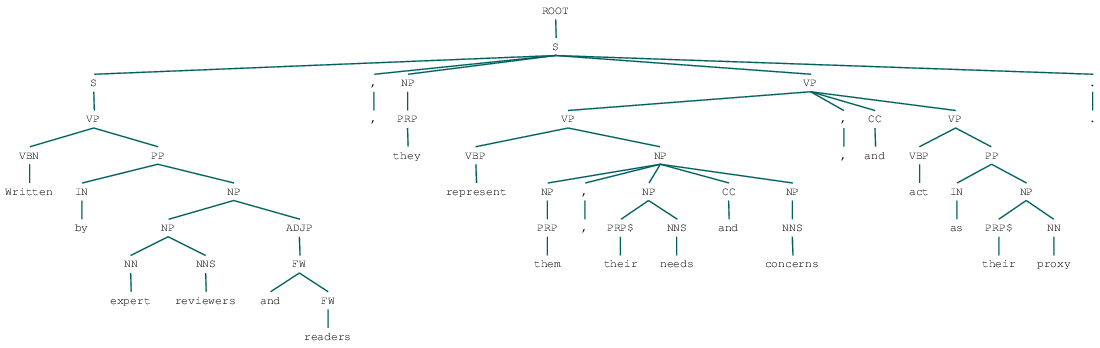

stress:  [u'expert', u'reviewers', u'needs', u'concerns', u'proxy']
topic:  [u'they']


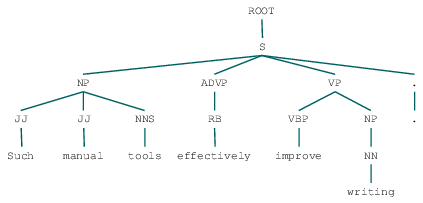

stress:  [u'writing']
topic:  [u'tools']


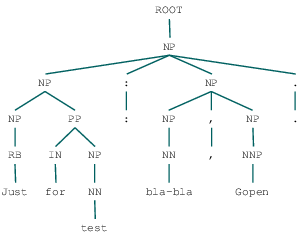

stress:  [u'test', u'bla-bla', u'Gopen']
topic:  []
2 PAR ITER
4
_par_iter: 3
_sent_iter: 10
0


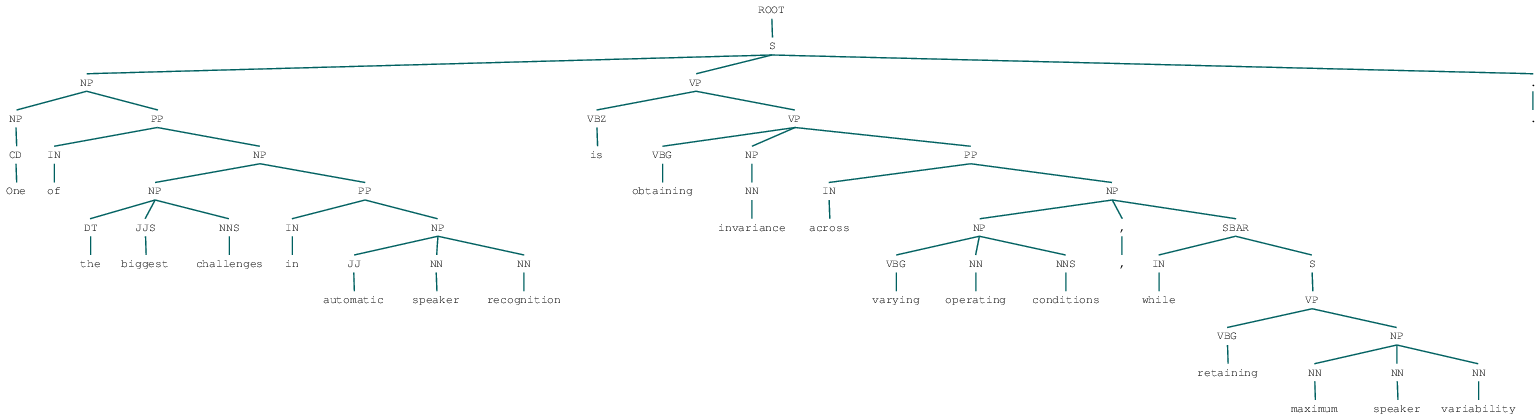

stress:  [u'challenges', u'speaker', u'recognition', u'obtaining', u'invariance', u'varying', u'operating', u'conditions', u'retaining', u'maximum', u'speaker', u'variability']
topic:  [u'One']
3 PAR ITER
4
_par_iter: 4
_sent_iter: 2


'\ntext.nextPar()\ntext.nextPar()\nsent, p = text.nextSent()\na = (SentInfo(sent, UNKNOWN))\na.setDefaultWordSet()\nprint "stress: ", a.stress_words\nprint "topic: ", a.topic_words\n'

In [72]:
#проверка алгоритма(поиск defaultWordSet для каждого предложения)
state = 0
text = SourceText(paragraphs)
sent_list = []

while state == 0:
    print state
    sent, p = text.nextSent()
    while p != 1:
        sent_list.append(SentInfo(sent, UNKNOWN))
        sent_list[-1].setDefaultWordSet()
        sent, p = text.nextSent()
        print "stress: ", sent_list[-1].stress_words
        print "topic: ", sent_list[-1].topic_words
    state = text.nextPar()

'''
text.nextPar()
text.nextPar()
sent, p = text.nextSent()
a = (SentInfo(sent, UNKNOWN))
a.setDefaultWordSet()
print "stress: ", a.stress_words
print "topic: ", a.topic_words
'''

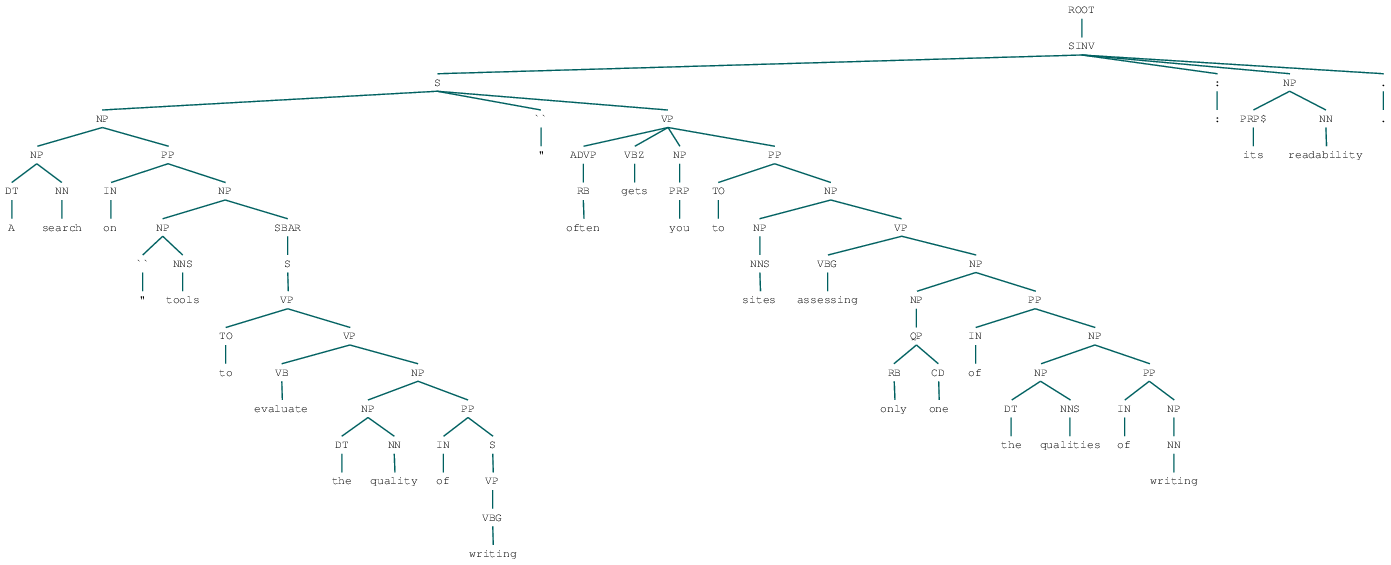

[(u'Measuring', u'VBG'), (u'ease', u'NN'), (u'of', u'IN'), (u'reading', u'NN'), (u'is', u'VBZ'), (u'indeed', u'RB'), (u'useful', u'JJ'), (u'to', u'TO'), (u'determine', u'VB'), (u'if', u'IN'), (u'your', u'PRP$'), (u'writing', u'NN'), (u'meets', u'VBZ'), (u'the', u'DT'), (u'reading', u'NN'), (u'level', u'NN'), (u'of', u'IN'), (u'your', u'PRP$'), (u'targeted', u'VBN'), (u'reader', u'NN'), (u',', u','), (u'but', u'CC'), (u'with', u'IN'), (u'scientific', u'JJ'), (u'writing', u'NN'), (u',', u','), (u'the', u'DT'), (u'statistical', u'JJ'), (u'formulae', u'NN'), (u'and', u'CC'), (u'readability', u'NN'), (u'indices', u'NNS'), (u'such', u'JJ'), (u'as', u'IN'), (u'Flesch-Kincaid', u'NNP'), (u'lose', u'VBP'), (u'their', u'PRP$'), (u'usefulness', u'NN'), (u'.', u'.')] 0
else


NameError: name 'checkSentenceProgression' is not defined

In [67]:
state = 0
text = SourceText(paragraphs)
sent_list = []
'''
while state == 0:
    sent, p = text.nextSent()
    sent_list.append(SentInfo(sent, NOT_APPLICABLE))
    sent_list[-1].setDefaultWordSet()
    sent, p = text.nextSent()
    while p != 1:
        sent_list.append(SentInfo(sent), UNKNOWN)
        sent_list[-1].checkPlaceboTransitions()
        print "stress: ", sent_list[-1].stress_words
        print "topic: ", sent_list[-1].topic_words
    state = text.nextPar()
'''
sent, p = text.nextSent()
sent_list.append(SentInfo(sent, NOT_APPLICABLE))
sent_list[-1].setDefaultWordSet()
sent, p = text.nextSent()
sent_list.append(SentInfo(sent, UNKNOWN))
sent_list[-1].checkPlaceboTransitions()
print sent_list[-1].sent, sent_list[-1].hasPlaceboTransitions
if sent_list[-1].sentenceBeginsWithFluidWords():
    sent_list[-1].type = FLUID
    sent_list[-1].setDefaultWordSet()
else:
    print "else"
    checkSentenceProgression